In [ ]:
!pip install pandas matplotlib scikit-learn ucimlrepo seaborn

# Tugas 2 Linear Regressions | Kelompok 4


## Import Libraries


In [ ]:
from ucimlrepo import fetch_ucirepo
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Read dataset

In [ ]:
# fetch dataset
individual_household_electric_power_consumption = fetch_ucirepo(id=235)

# data (as pandas dataframes)
X = individual_household_electric_power_consumption.data.features
y = individual_household_electric_power_consumption.data.targets

# metadata
print(individual_household_electric_power_consumption.metadata)

# variable information
print(individual_household_electric_power_consumption.variables)


/usr/local/lib/python3.11/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


{'uci_id': 235, 'name': 'Individual Household Electric Power Consumption', 'repository_url': 'https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption', 'data_url': 'https://archive.ics.uci.edu/static/public/235/data.csv', 'abstract': 'Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.', 'area': 'Physics and Chemistry', 'tasks': ['Regression', 'Clustering'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 2075259, 'num_features': 9, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2006, 'last_updated': 'Fri Mar 08 2024', 'dataset_doi': '10.24432/C58K54', 'creators': ['Georges Hebrail', 'Alice Berard'], 'intro_paper': None, 'additional_info': {'summary': 'This archiv

In [ ]:
df = pd.concat([X, y], axis=1)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


## Data preparations

In [ ]:
df.dtypes

,0
Date,object
Time,object
Global_active_power,object
Global_reactive_power,object
Voltage,object
Global_intensity,object
Sub_metering_1,object
Sub_metering_2,object
Sub_metering_3,float64


### Combine both column into DateTime format

In [ ]:
# combine both Date and Time into 1 col
df['Date'] = df['Date'].astype(str) + ' ' + df['Time']
df = df.rename({'Date': 'DateTime'}, axis=1) # rename column into DateTime
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%Y %H:%M:%S', dayfirst=True)

# Remove unused Time column
df = df.drop(['Time'], axis=1)

# Change other column dtype
for col in df.columns:
    if col != 'DateTime':
        df[col] = pd.to_numeric(df[col], errors='coerce')


In [ ]:
df.head()


,DateTime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   DateTime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


### Columns info


1. date: Date in format dd/mm/yyyy
2. time: time in format hh:mm:ss
3. global_active_power: household global minute-averaged active power (in kilowatt)
4. global_reactive_power: household global minute-averaged reactive power (in kilowatt)
5. voltage: minute-averaged voltage (in volt)
6. global_intensity: household global minute-averaged current intensity (in ampere)
7. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
8. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
9. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

### Rename columns name

In [ ]:
df = df.rename({
    'Sub_metering_1': 'Sub_metering_kitchen',
    'Sub_metering_2': 'Sub_metering_laundry'}, axis=1)


## Dataaset Size & Null Values

In [ ]:
df.shape

(2075259, 8)

In [ ]:
df.isna().sum()

,0
DateTime,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_kitchen,25979
Sub_metering_laundry,25979
Sub_metering_3,25979


In [ ]:
df.duplicated().sum()

np.int64(0)

## Null Values percentage

In [ ]:
print("pesentase nilai null dari dataset")
for col in df.columns:
    print(f"{col}: {df[col].isna().sum()/len(df[col])*100:.2f}%")


pesentase nilai null dari dataset
DateTime: 0.00%
Global_active_power: 1.25%
Global_reactive_power: 1.25%
Voltage: 1.25%
Global_intensity: 1.25%
Sub_metering_kitchen: 1.25%
Sub_metering_laundry: 1.25%
Sub_metering_3: 1.25%


### Fill Null With Median

In [ ]:
df = df.fillna(df[col].median())
df.isna().sum()


,0
DateTime,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_kitchen,0
Sub_metering_laundry,0
Sub_metering_3,0


## Statisctical informations

In [ ]:
df.describe().round(3)


,DateTime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_kitchen,Sub_metering_laundry,Sub_metering_3
count,2075259,2075259.000,2075259.000,2075259.000,2075259.000,2075259.000,2075259.000,2075259.000
mean,2008-12-06 07:12:59.999994112,1.090,0.135,237.837,4.582,1.120,1.295,6.390
min,2006-12-16 17:24:00,0.076,0.000,1.000,0.200,0.000,0.000,0.000
25%,2007-12-12 00:18:30,0.310,0.048,238.890,1.400,0.000,0.000,0.000
50%,2008-12-06 07:13:00,0.630,0.102,240.960,2.600,0.000,0.000,1.000
75%,2009-12-01 14:07:30,1.520,0.198,242.860,6.400,0.000,1.000,17.000
max,2010-11-26 21:02:00,11.122,1.390,254.150,48.400,88.000,80.000,31.000
std,NaN,1.051,0.148,26.860,4.435,6.114,5.786,8.406


## Data Visualizations


### Time Series


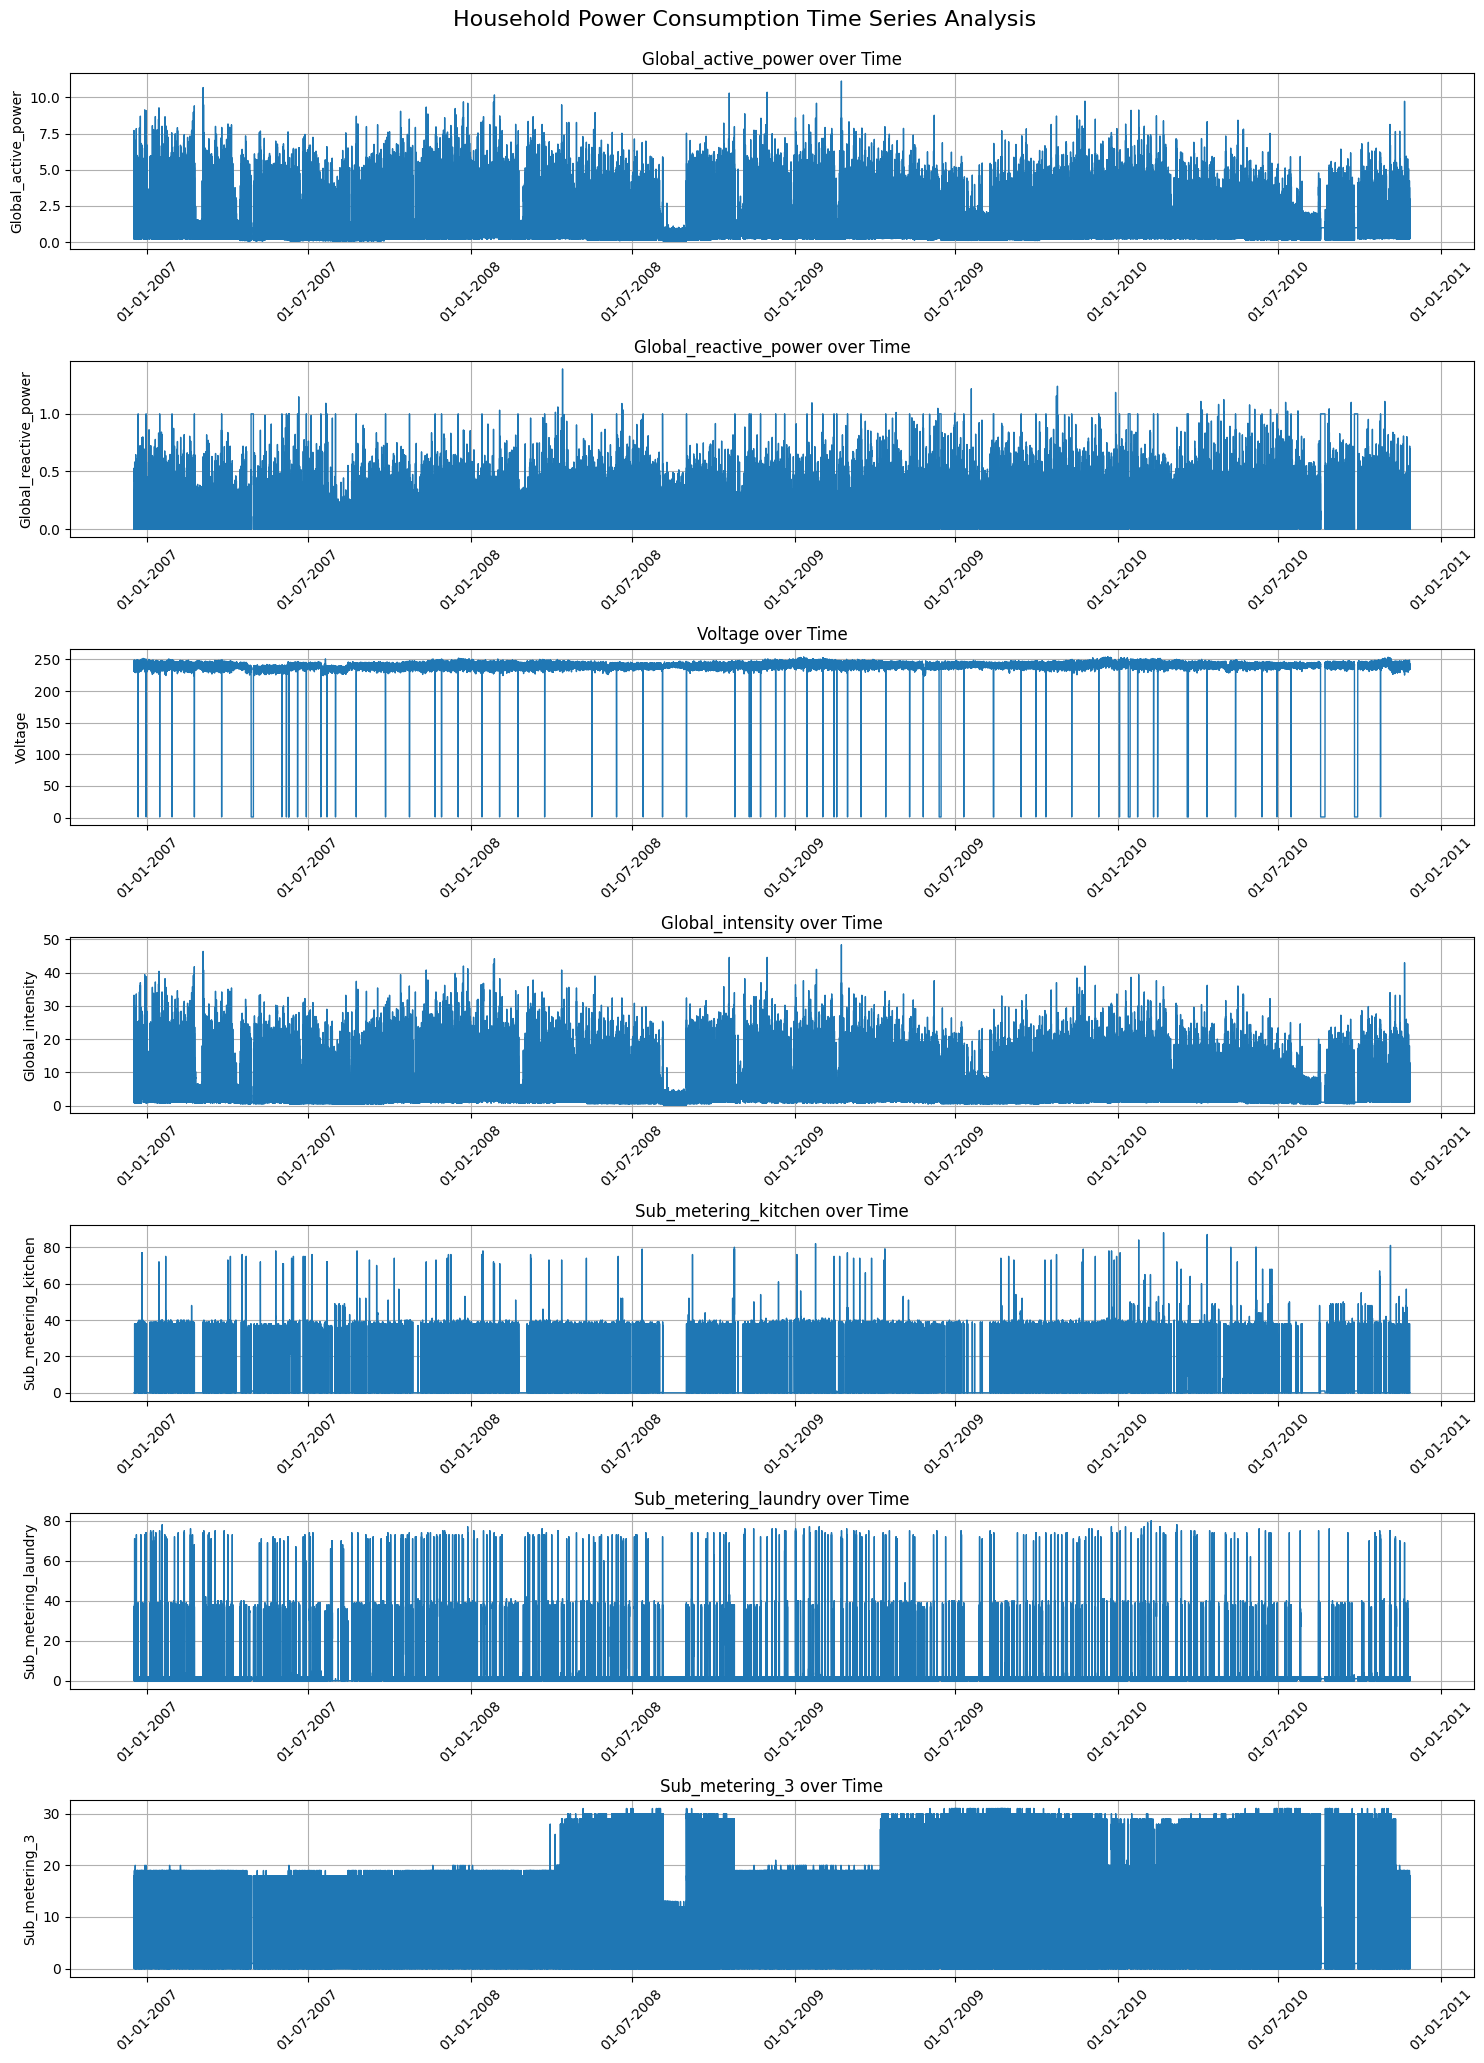

In [ ]:
# Get numeric columns (excluding 'DateTime')
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Create subplots
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(15, 3*len(numeric_cols)))
fig.suptitle('Household Power Consumption Time Series Analysis', fontsize=16)

# Format the date on x-axis
date_format = mdates.DateFormatter('%d-%m-%Y')

# Ensure axes is iterable (even if there's only one plot)
if len(numeric_cols) == 1:
    axes = [axes]

# Plot each numeric column against the DateTime column
for i, col in enumerate(numeric_cols):
    axes[i].plot(df['DateTime'], df[col], linewidth=1)
    axes[i].set_title(f'{col} over Time')
    axes[i].set_ylabel(col)
    axes[i].grid(True)
    axes[i].xaxis.set_major_formatter(date_format)
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.subplots_adjust(top=0.95)

# plt.savefig('time_series_plots.png', dpi=300)

plt.show()


### Daily paterns

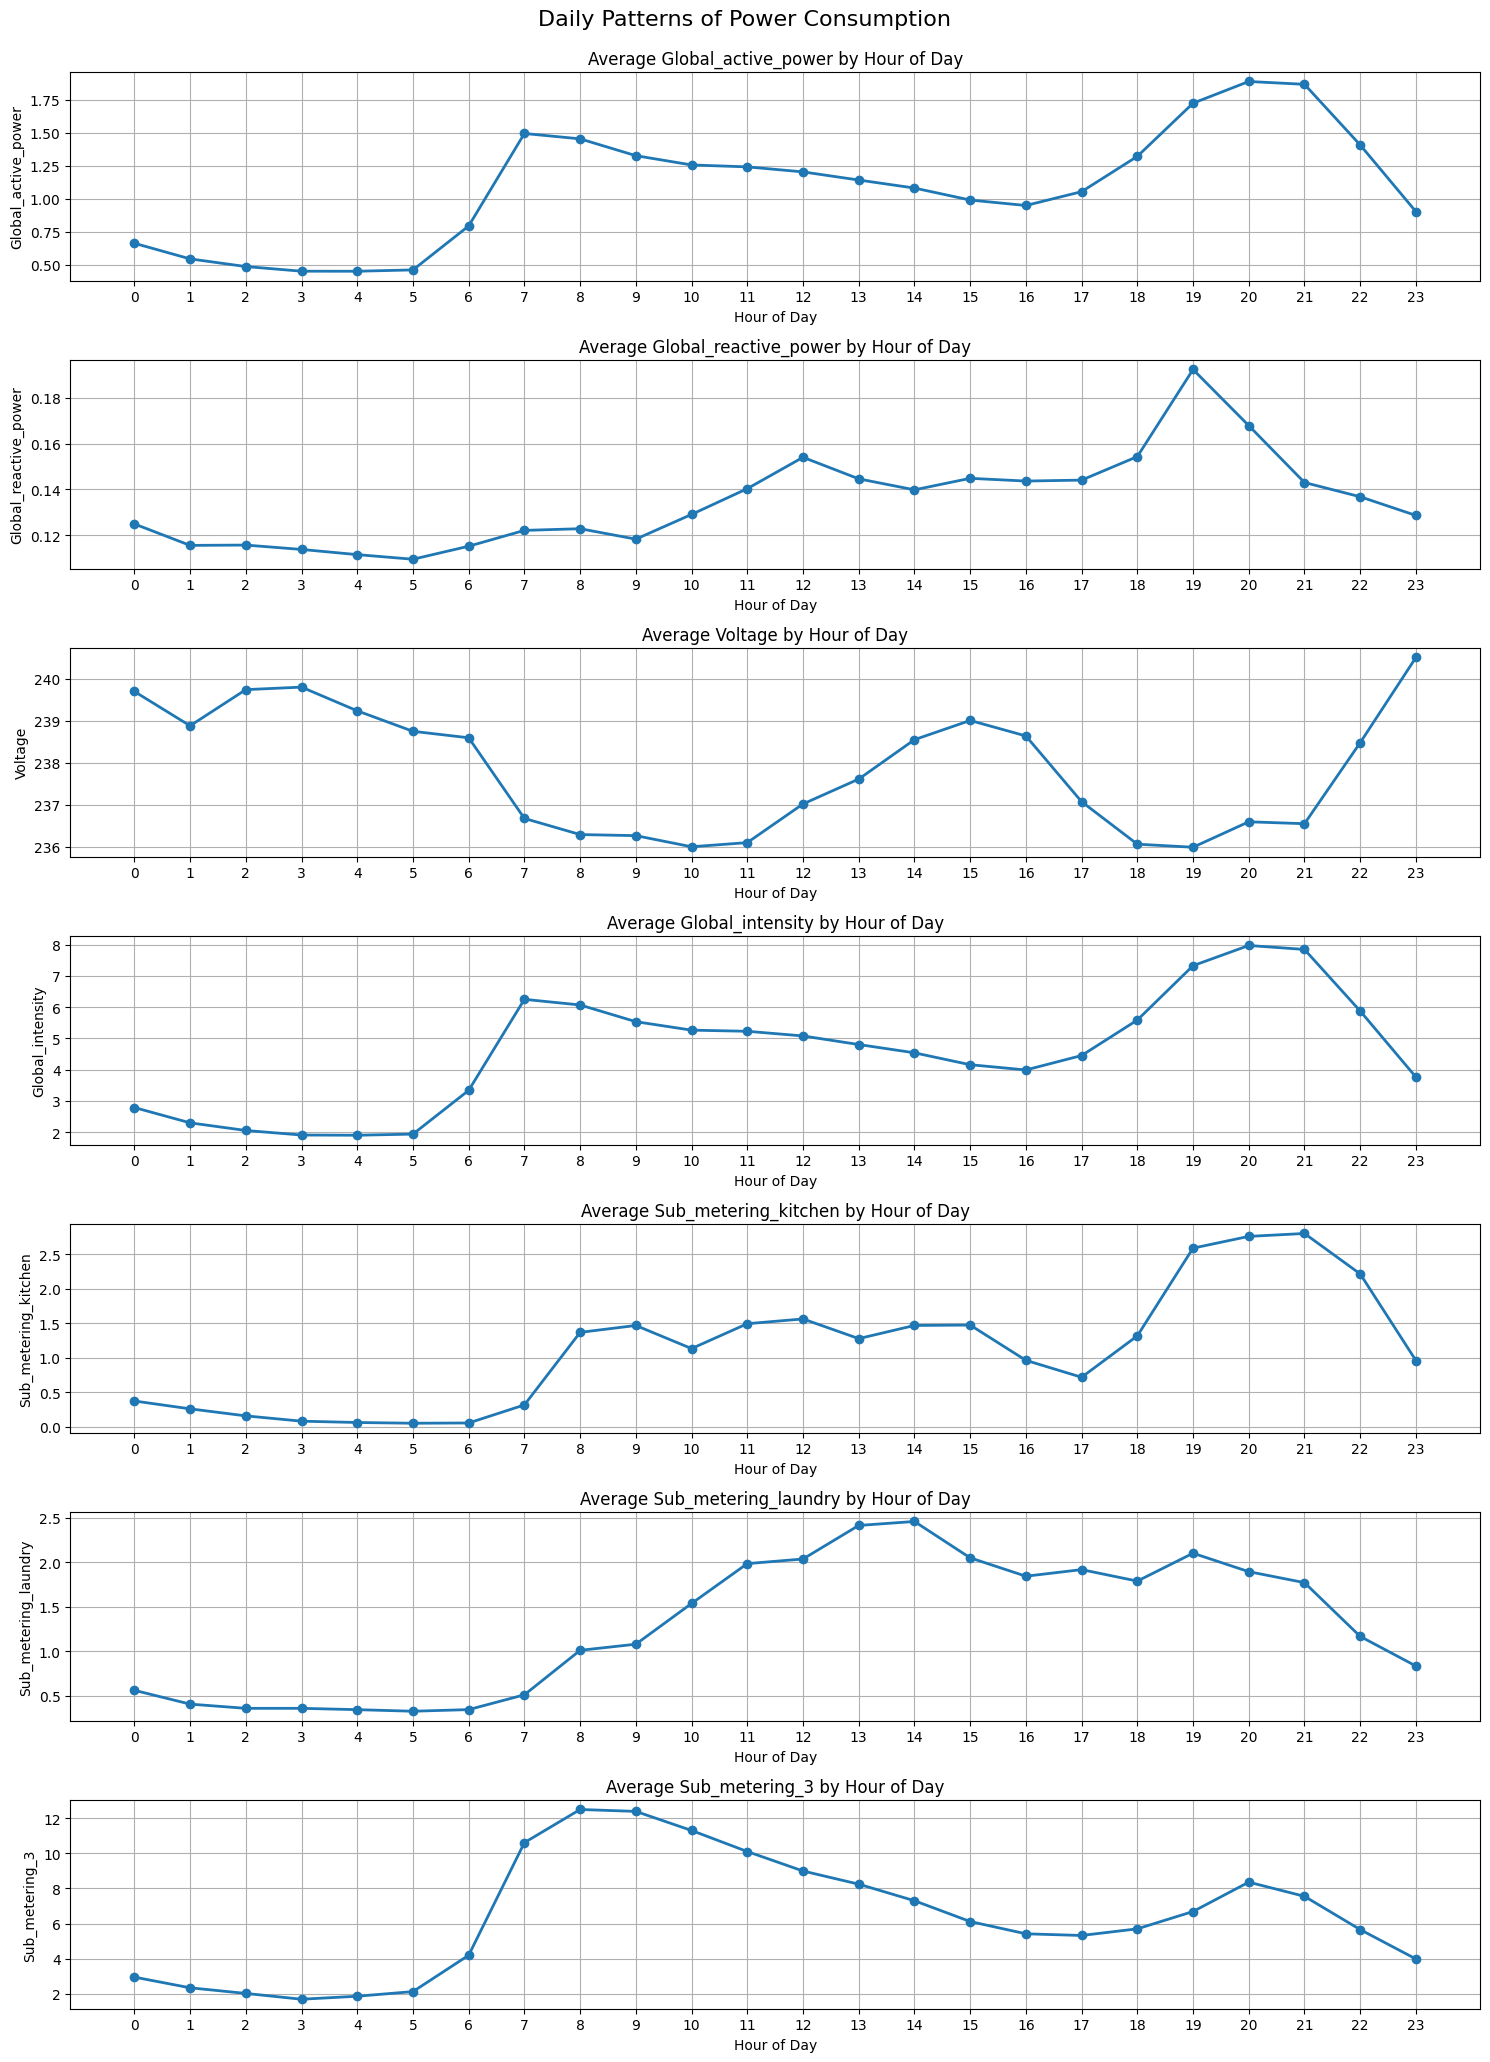

In [ ]:
# Add hour column
df_hourly = df.copy()
df_hourly['hour'] = df_hourly['DateTime'].dt.hour

# Group by hour and calculate mean
hourly_avg = df_hourly.groupby('hour').mean()

# Get numeric columns excluding hour
numeric_cols = df_hourly.select_dtypes(include=[np.number]).columns.tolist()
if 'hour' in numeric_cols:
    numeric_cols.remove('hour')

# Plot daily patterns
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(15, 3*len(numeric_cols)))
fig.suptitle('Daily Patterns of Power Consumption', fontsize=16)

for i, col in enumerate(numeric_cols):
    axes[i].plot(hourly_avg.index, hourly_avg[col], marker='o', linewidth=2)
    axes[i].set_title(f'Average {col} by Hour of Day')
    axes[i].set_xlabel('Hour of Day')
    axes[i].set_ylabel(col)
    axes[i].grid(True)
    axes[i].set_xticks(range(0, 24))

plt.tight_layout()
plt.subplots_adjust(top=0.95)

# plt.savefig('daily_patterns.png', dpi=300)

plt.show()

### Sub Metering Comparison

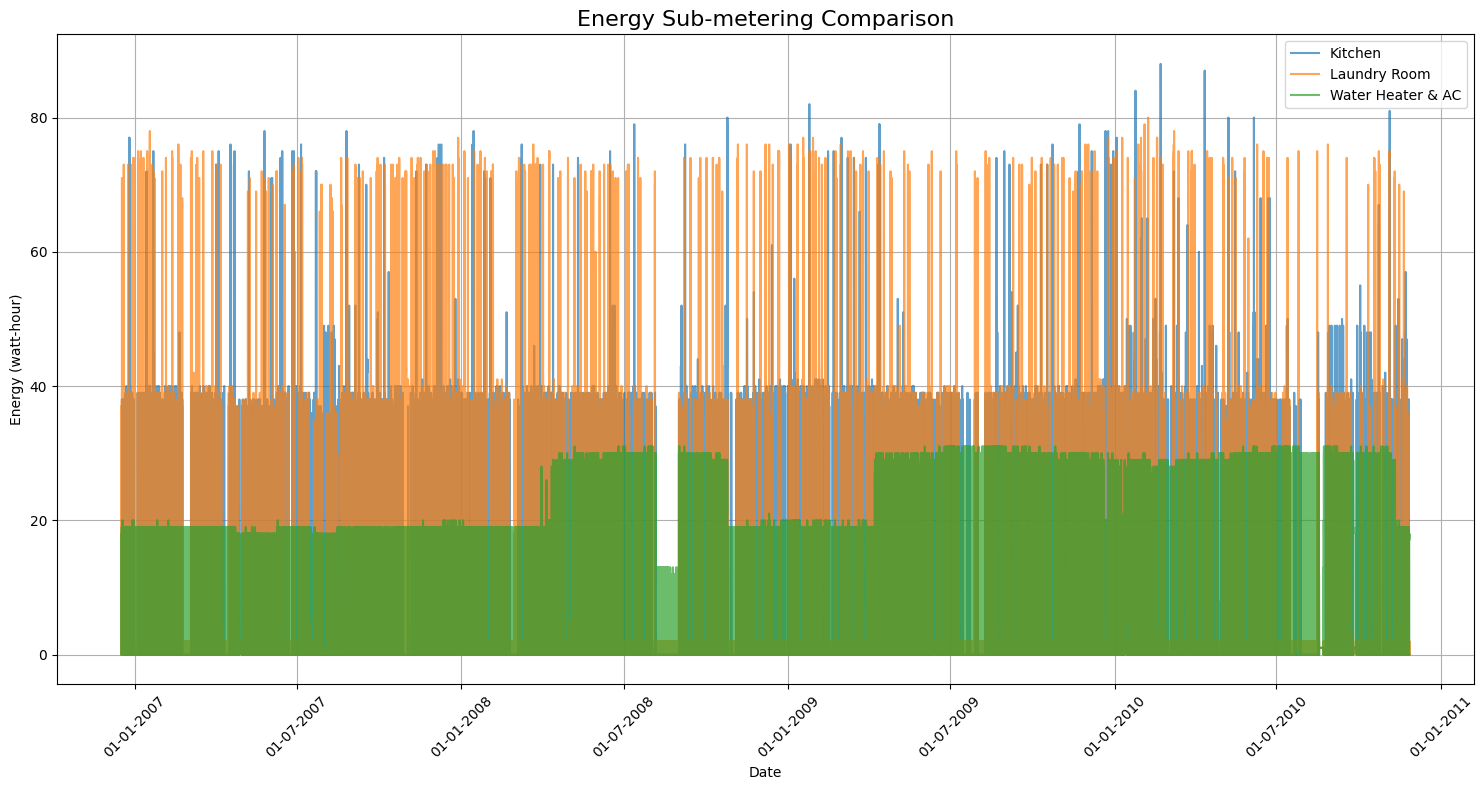

In [ ]:
# Create a figure
plt.figure(figsize=(15, 8))

# Plot sub-metering data
plt.plot(df['DateTime'], df['Sub_metering_kitchen'], label='Kitchen', alpha=0.7)
plt.plot(df['DateTime'], df['Sub_metering_laundry'], label='Laundry Room', alpha=0.7)
plt.plot(df['DateTime'], df['Sub_metering_3'], label='Water Heater & AC', alpha=0.7)

# Add labels and title
plt.title('Energy Sub-metering Comparison', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Energy (watt-hour)')
plt.legend()
plt.grid(True)

# Format the date on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.xticks(rotation=45)

plt.tight_layout()

# plt.savefig('sub_metering_comparison.png', dpi=300)

plt.show()

### Correlations Heatmap

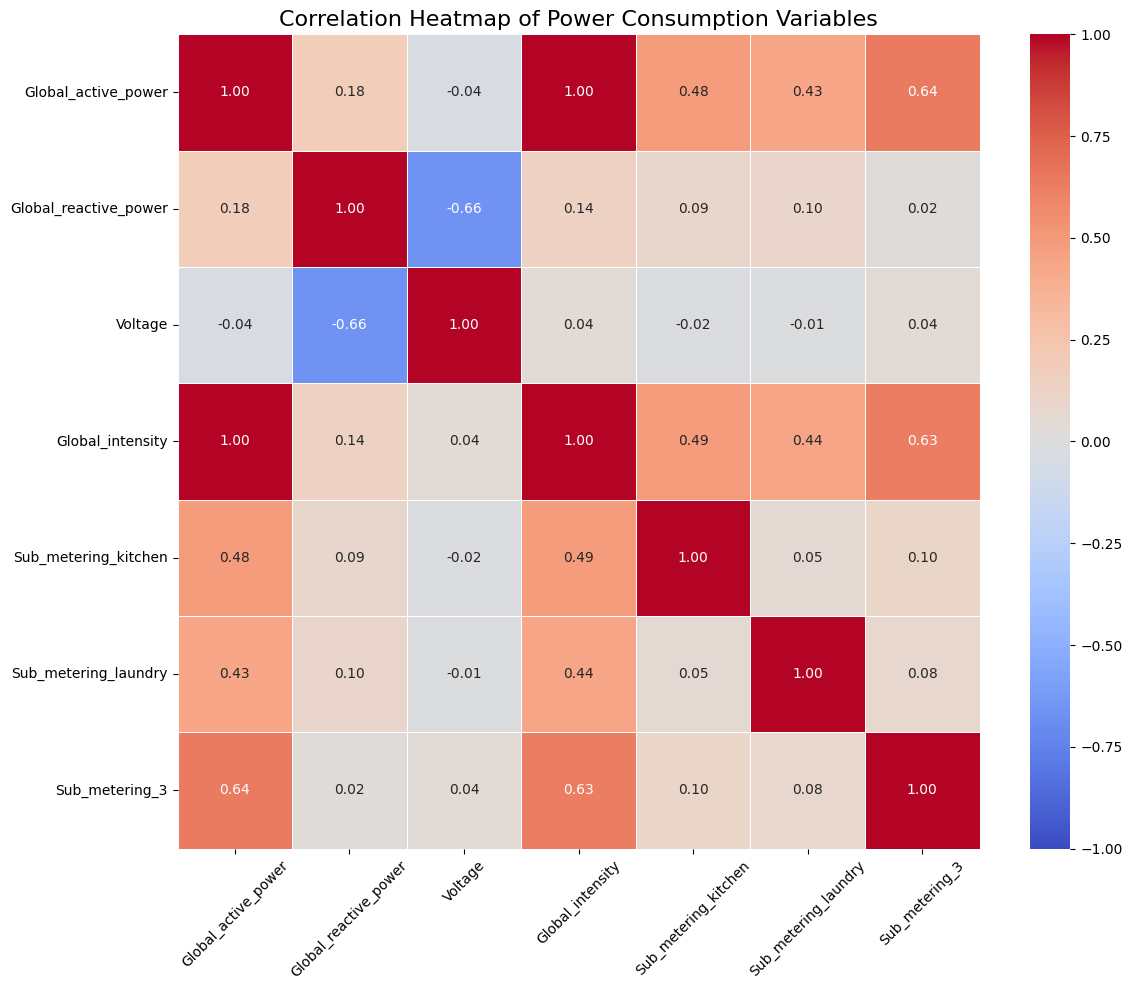

In [ ]:
# Select numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Create a figure
plt.figure(figsize=(12, 10))

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f',
            linewidths=0.5, vmin=-1, vmax=1)

plt.xticks(rotation=45)

plt.title('Correlation Heatmap of Power Consumption Variables', fontsize=16)
plt.tight_layout()

# plt.savefig('correlation_heatmap.png', dpi=300)

plt.show()

### Weekday-Weekend Comparison

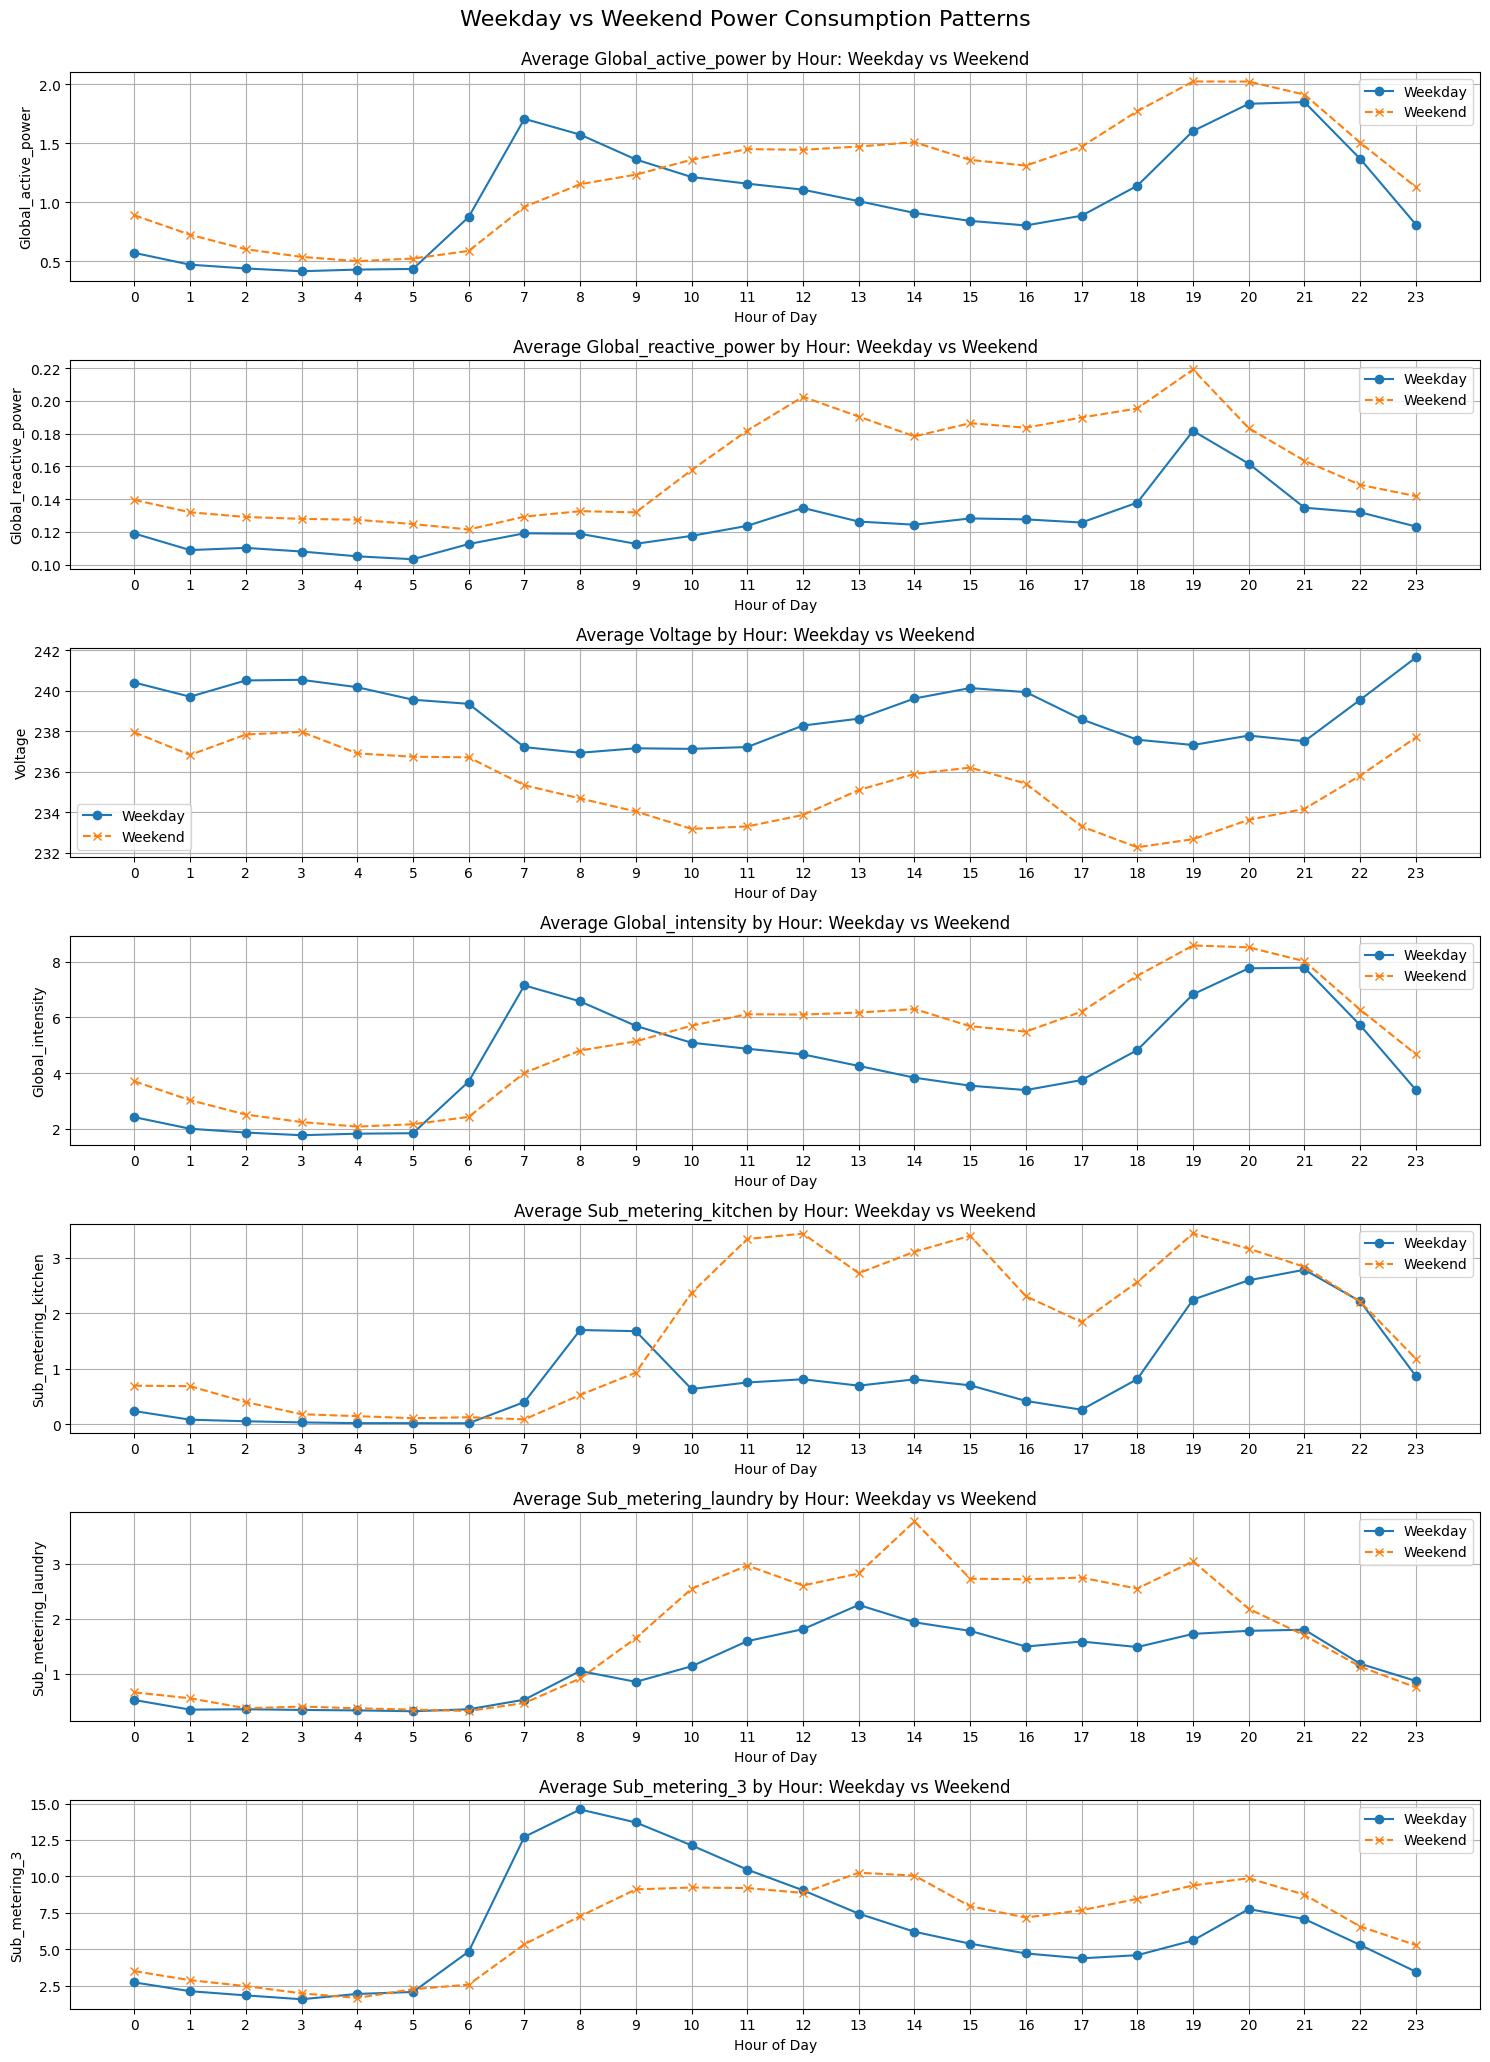

In [ ]:
# Add day of week and weekend columns
df_with_day = df.copy()
df_with_day['day_of_week'] = df_with_day['DateTime'].dt.dayofweek
df_with_day['hour'] = df_with_day['DateTime'].dt.hour
df_with_day['is_weekend'] = df_with_day['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Group by hour and weekend flag
hourly_group = df_with_day.groupby(['hour', 'is_weekend']).mean()

# Reset index to have hour and is_weekend as columns
hourly_pivot = hourly_group.reset_index()

# Split data into weekday and weekend
weekday_data = hourly_pivot[hourly_pivot['is_weekend'] == 0]
weekend_data = hourly_pivot[hourly_pivot['is_weekend'] == 1]

# Get numeric columns excluding day_of_week, hour, and is_weekend
numeric_cols = df_with_day.select_dtypes(include=[np.number]).columns.tolist()
cols_to_exclude = ['day_of_week', 'hour', 'is_weekend']
for col in cols_to_exclude:
    if col in numeric_cols:
        numeric_cols.remove(col)

# Plot the comparison
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(15, 3*len(numeric_cols)))
fig.suptitle('Weekday vs Weekend Power Consumption Patterns', fontsize=16)

for i, col in enumerate(numeric_cols):
    try:
        axes[i].plot(weekday_data['hour'], weekday_data[col],
                        label='Weekday', marker='o', linestyle='-')
        axes[i].plot(weekend_data['hour'], weekend_data[col],
                        label='Weekend', marker='x', linestyle='--')
        axes[i].set_title(f'Average {col} by Hour: Weekday vs Weekend')
        axes[i].set_xlabel('Hour of Day')
        axes[i].set_ylabel(col)
        axes[i].grid(True)
        axes[i].legend()
        axes[i].set_xticks(range(0, 24))
    except Exception as e:
        print(f"Error plotting {col}: {e}")

plt.tight_layout()
plt.subplots_adjust(top=0.95)

# plt.savefig('weekday_weekend_comparison.png', dpi=300)

plt.show()


## Values Distributions

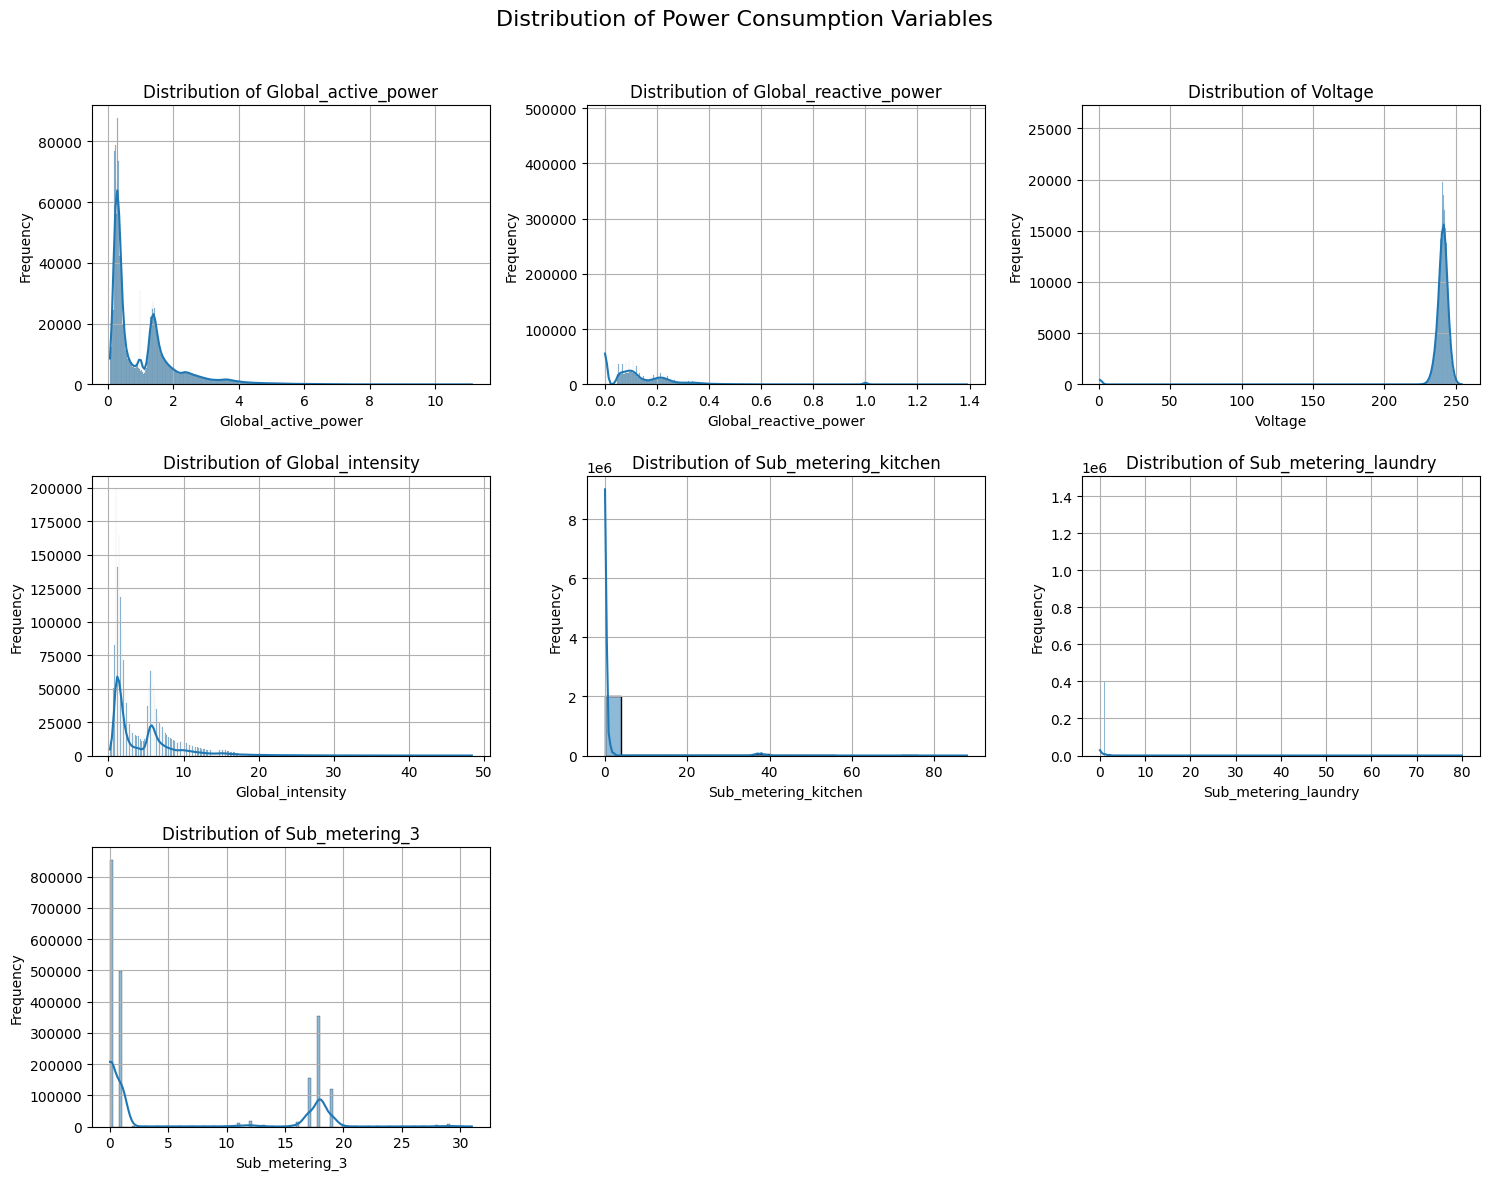

In [ ]:
# Get numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Number of columns for the subplot grid
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
fig.suptitle('Distribution of Power Consumption Variables', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each column
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.90)

# plt.savefig('distribution_plo|ts.png', dpi=300)

plt.show()


### Power Relations

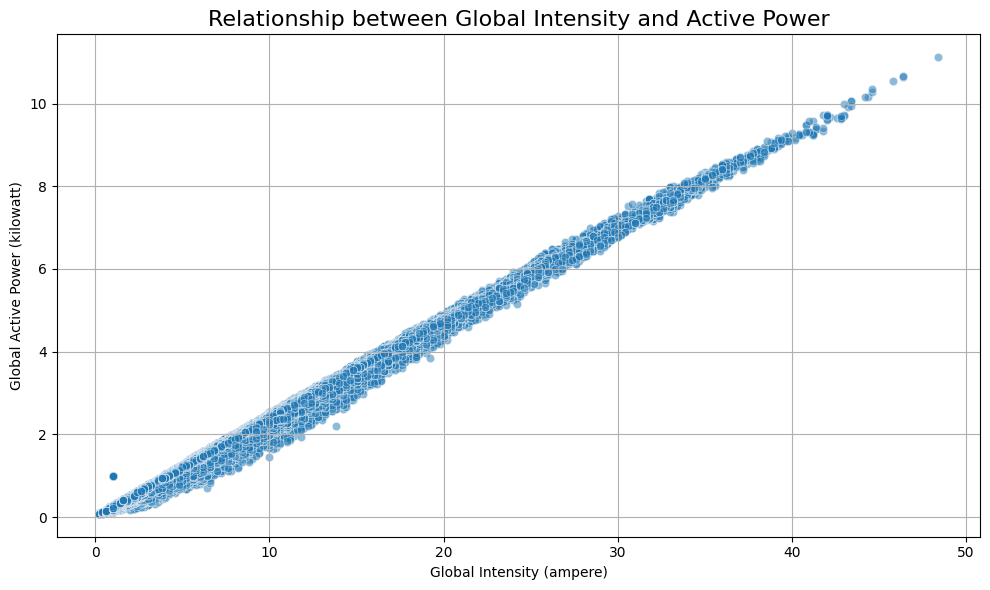

In [ ]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x='Global_intensity', y='Global_active_power', data=df, alpha=0.5)

plt.title('Relationship between Global Intensity and Active Power', fontsize=16)
plt.xlabel('Global Intensity (ampere)')
plt.ylabel('Global Active Power (kilowatt)')
plt.grid(True)

plt.tight_layout()

# plt.savefig('power_intensity_relation.png', dpi=300)

plt.show()


## Model Training

### Linear Regression

In [ ]:
# Membuat salinan dataset
df_train = df.copy()

# Membuat fitur waktu dari DateTime
df_train['hour'] = df_train['DateTime'].dt.hour
df_train['day_of_week'] = df_train['DateTime'].dt.dayofweek
df_train['month'] = df_train['DateTime'].dt.month

# Memisahkan fitur dan target
X = df_train[['Global_reactive_power', 'Voltage', 'Global_intensity',
             'Sub_metering_kitchen', 'Sub_metering_laundry', 'Sub_metering_3',
             'hour', 'day_of_week', 'month']]

y = df_train['Global_active_power']

# Membagi data menjadi training dan testing set (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Membuat dan melatih model regresi linear
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Prediksi
y_pred_linear = linear_model.predict(X_test_scaled)

### Polinomial Regression

In [ ]:
poly = PolynomialFeatures(degree=2)

X_poly_train = poly.fit_transform(X_train_scaled)
X_poly_test = poly.transform(X_test_scaled)

# melatih model regresi dengan degree 2
poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_train)

# Prediksi
y_pred_poly = poly_model.predict(X_poly_test)

## Evaluasi Model

In [ ]:
print("=== Evaluasi Regresi Linear ===")
mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"MSE  : {mse_linear:.4f}")
print(f"MAE  : {mae_linear:.4f}")
print(f"R²   : {r2_linear:.4f}")

print("\n=== Evaluasi Regresi Polinomial (Degree 2) ===")
mse_poly = mean_squared_error(y_test, y_pred_poly)
mae_poly = mean_absolute_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f"MSE  : {mse_poly:.4f}")
print(f"MAE  : {mae_poly:.4f}")
print(f"R²   : {r2_poly:.4f}")

# Perbandingan singkat
print("\n=== Perbandingan Singkat ===")
improvement_r2 = r2_poly - r2_linear
print(f"Perbedaan R² Polynomial vs Linear: {improvement_r2:.4f}")


=== Evaluasi Regresi Linear ===
MSE  : 0.0022
MAE  : 0.0317
R²   : 0.9980

=== Evaluasi Regresi Polinomial (Degree 2) ===
MSE  : 0.0013
MAE  : 0.0217
R²   : 0.9988

=== Perbandingan Singkat ===
Perbedaan R² Polynomial vs Linear: 0.0008


In [ ]:
# Koefisien Regresi Linear
print("\nKoefisien Regresi Linear:")
coefficients_linear = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': linear_model.coef_
}).sort_values(by='Coefficient', ascending=False)
print(f"Intercept: {linear_model.intercept_}")
print(coefficients_linear)

# Koefisien Regresi Polinomial
print("\nKoefisien Regresi Polinomial:")
feature_names_poly = poly.get_feature_names_out(input_features=X.columns)
coefficients_poly = pd.DataFrame({
    'Feature': feature_names_poly,
    'Coefficient': poly_model.coef_
}).sort_values(by='Coefficient', ascending=False)
print(f"Intercept: {poly_model.intercept_}")
print(coefficients_poly)


Koefisien Regresi Linear:
Intercept: 1.0902748500638764
                 Feature  Coefficient
2       Global_intensity     1.042555
5         Sub_metering_3     0.018652
6                   hour     0.001383
7            day_of_week     0.000284
8                  month    -0.000858
3   Sub_metering_kitchen    -0.001326
4   Sub_metering_laundry    -0.001792
0  Global_reactive_power    -0.022841
1                Voltage    -0.098912

Koefisien Regresi Polinomial:
Intercept: 1.0626307620571225
                                       Feature   Coefficient
3                             Global_intensity  1.045335e+00
20                    Voltage Global_intensity  1.195923e-01
2                                      Voltage  9.981926e-02
6                               Sub_metering_3  1.973381e-02
19                                   Voltage^2  1.836870e-02
12      Global_reactive_power Global_intensity  9.732062e-03
34                      Sub_metering_kitchen^2  5.203808e-03
31            

=== Feature Importance (Linear Regression) ===
                 Feature  Linear Coefficient  Absolute Importance
2       Global_intensity            1.042555             1.042555
1                Voltage           -0.098912             0.098912
0  Global_reactive_power           -0.022841             0.022841
5         Sub_metering_3            0.018652             0.018652
4   Sub_metering_laundry           -0.001792             0.001792
6                   hour            0.001383             0.001383
3   Sub_metering_kitchen           -0.001326             0.001326
8                  month           -0.000858             0.000858
7            day_of_week            0.000284             0.000284


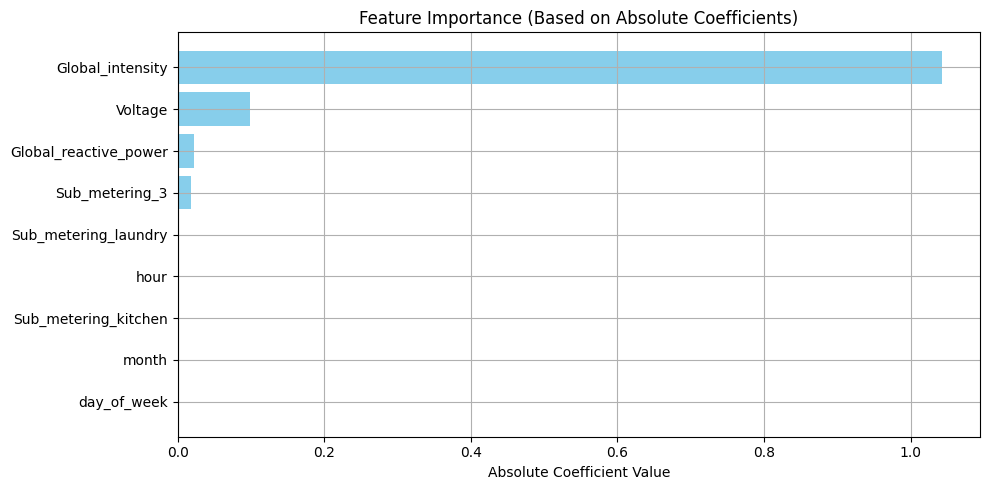

In [ ]:
# Koefisien dari model linear
coef_linear = linear_model.coef_

# Buat dataframe untuk fitur dan importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Linear Coefficient': coef_linear,
    'Absolute Importance': np.abs(coef_linear)
}).sort_values(by='Absolute Importance', ascending=False)

print("=== Feature Importance (Linear Regression) ===")
print(importance_df)

# Visualisasi
plt.figure(figsize=(10, 5))
plt.barh(importance_df['Feature'], importance_df['Absolute Importance'], color='skyblue')
plt.title("Feature Importance (Based on Absolute Coefficients)")
plt.xlabel("Absolute Coefficient Value")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


=== Top 10 Feature Interactions (Polynomial) ===
                                   Feature  Coefficient  Absolute Importance
3                         Global_intensity     1.045335             1.045335
20                Voltage Global_intensity     0.119592             0.119592
2                                  Voltage     0.099819             0.099819
1                    Global_reactive_power    -0.023774             0.023774
4                     Sub_metering_kitchen    -0.019763             0.019763
6                           Sub_metering_3     0.019734             0.019734
19                               Voltage^2     0.018369             0.018369
21            Voltage Sub_metering_kitchen    -0.009951             0.009951
12  Global_reactive_power Global_intensity     0.009732             0.009732
10                 Global_reactive_power^2    -0.007940             0.007940


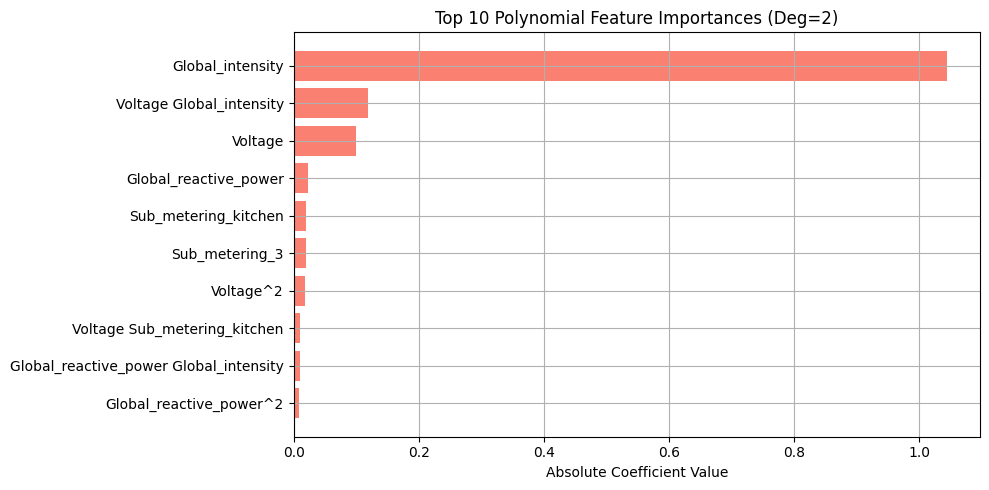

In [ ]:
feature_names = poly.get_feature_names_out(input_features=X.columns)
coef_poly = poly_model.coef_

poly_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef_poly,
    'Absolute Importance': np.abs(coef_poly)
}).sort_values(by='Absolute Importance', ascending=False)

print("=== Top 10 Feature Interactions (Polynomial) ===")
print(poly_importance_df.head(10))

# Visualisasi untuk Polynomial Regression
plt.figure(figsize=(10, 5))
plt.barh(poly_importance_df.head(10)['Feature'],
         poly_importance_df.head(10)['Absolute Importance'],
         color='salmon')
plt.title("Top 10 Polynomial Feature Importances (Deg=2)")
plt.xlabel("Absolute Coefficient Value")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-52-622a4c9907a9>:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


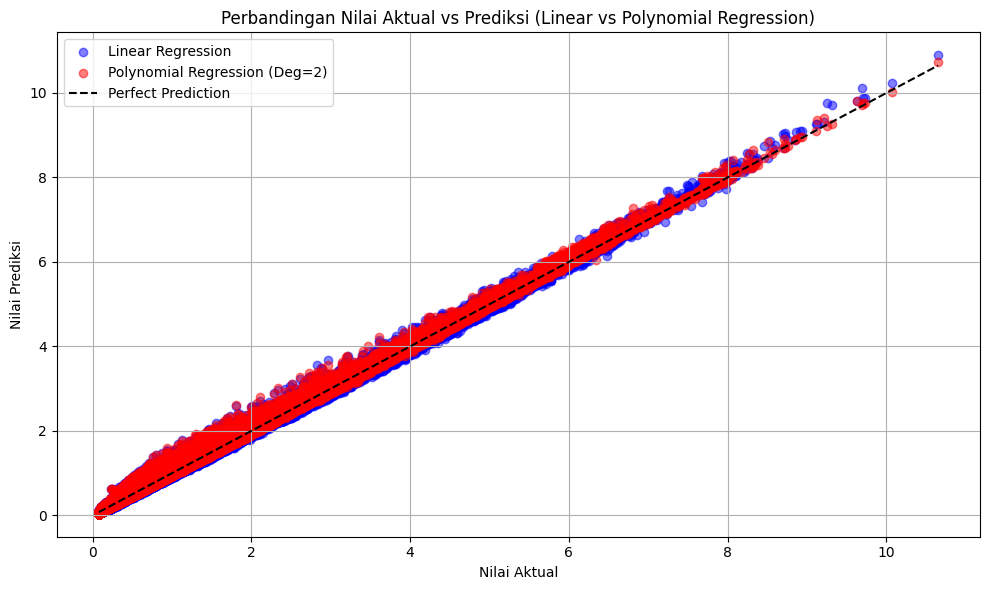

In [ ]:
plt.figure(figsize=(10, 6))

# Scatter plot untuk regresi linear
plt.scatter(y_test, y_pred_linear, alpha=0.5, color='blue', label='Linear Regression')

# Scatter plot untuk regresi polinomial
plt.scatter(y_test, y_pred_poly, alpha=0.5, color='red', label='Polynomial Regression (Deg=2)')

# Garis perfect prediction (ideal: y = y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='Perfect Prediction')

# Label dan estetika
plt.xlabel("Nilai Aktual")
plt.ylabel("Nilai Prediksi")
plt.title("Perbandingan Nilai Aktual vs Prediksi (Linear vs Polynomial Regression)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

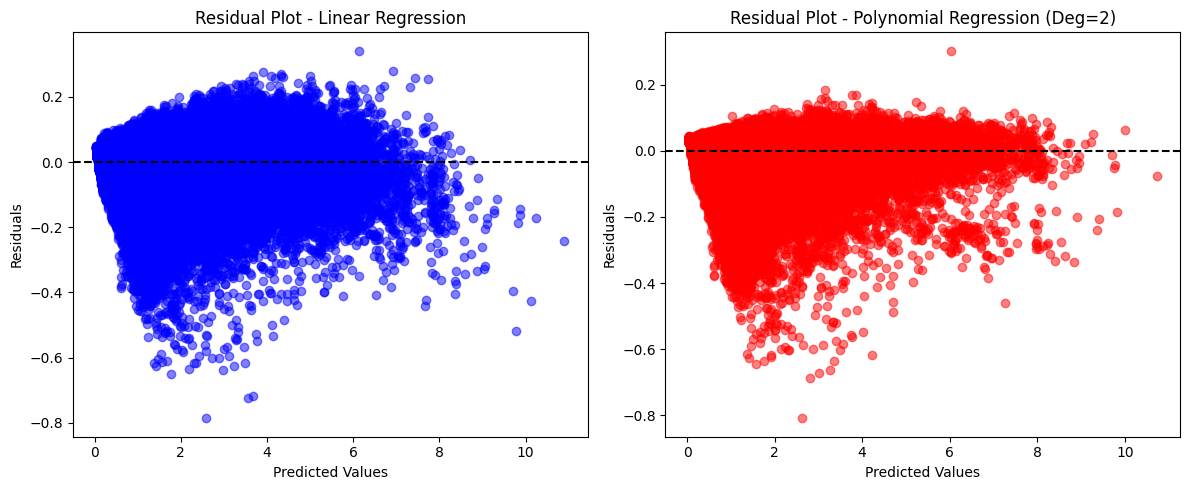

In [ ]:
# Hitung residual
residuals_linear = y_test - y_pred_linear
residuals_poly = y_test - y_pred_poly

# Visualisasi residual
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_linear, residuals_linear, alpha=0.5, color='blue')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Residual Plot - Linear Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

plt.subplot(1, 2, 2)
plt.scatter(y_pred_poly, residuals_poly, alpha=0.5, color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Residual Plot - Polynomial Regression (Deg=2)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()


In [ ]:
# # Evaluasi linear_model
# mse = mean_squared_error(y_test, y_pred_linear)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred_linear)

# # Menampilkan koefisien linear_model
# coefficients = pd.DataFrame({
#     'Feature': X.columns,
#     'Coefficient': linear_model.coef_
# }).sort_values(by='Coefficient', ascending=False)

# # Menampilkan hasil
# print(f"Mean Squared Error (MSE): {mse:.4f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
# print(f"R-squared (R²): {r2:.4f}")
# print("\nKoefisien linear_model:")
# print(coefficients)

# # Visualisasi hasil prediksi vs aktual
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_pred_linear, alpha=0.3)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
# plt.xlabel('Nilai Aktual')
# plt.ylabel('Nilai Prediksi')
# plt.title('Perbandingan Nilai Aktual vs Prediksi')
# plt.grid(True)
# plt.show()

# # Visualisasi koefisien fitur
# plt.figure(figsize=(12, 6))
# coefficients.plot(kind='bar', x='Feature', y='Coefficient')
# plt.title('Koefisien Fitur dalam Model Regresi Linear')
# plt.grid(axis='y')
# plt.tight_layout()
# plt.show()

# # Analisis Residual
# residuals = y_test - y_pred_linear
# plt.figure(figsize=(10, 6))
# plt.scatter(y_pred_linear, residuals, alpha=0.3)
# plt.axhline(y=0, color='r', linestyle='--')
# plt.xlabel('Nilai Prediksi')
# plt.ylabel('Residual')
# plt.title('Plot Residual')
# plt.grid(True)
# plt.show()

# # Mendapatkan pentingnya fitur secara absolut
# feature_importance = pd.DataFrame({
#     'Feature': X.columns,
#     'Importance': np.abs(linear_model.coef_)
# }).sort_values(by='Importance', ascending=False)

# print("\nPentingnya Fitur (berdasarkan nilai absolut koefisien):")
# print(feature_importance)